In [11]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

In [12]:
import tensorflow as tf
from tensorflow import keras

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [13]:
# we'll read both of these values and the original input and irrelevant tcrs
cdr3_to_X = pd.read_csv('../outputs/model_v3/cdr3.conversion.n30.csv', index_col=0)
ag_to_X = pd.read_csv('../outputs/model_v3/epitope.conversion.n15.csv', index_col=0)
hit = pd.read_csv('../outputs/model_v3/full.input.X.csv', index_col=0)
irr = pd.read_csv('../outputs/model_v3/full.control.X.csv', index_col=0)
irr = irr.reset_index().iloc[:, 1:]

In [14]:
# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

In [15]:
# assemble hold out
df_ext_X_hit = hit.loc[hit['Epitope'] == 'NLVPMVATV']
df_ext_X_irr = irr.loc[irr['Epitope'] == 'NLVPMVATV']
df_ext_y = pd.concat([pd.Series(np.ones(df_ext_X_hit.shape[0]), index=df_ext_X_hit),
                      pd.Series(np.zeros(df_ext_X_irr.shape[0]), index=df_ext_X_irr)], axis=0)
df_ext_X = pd.concat([df_ext_X_hit, df_ext_X_irr], axis=0).reset_index().iloc[:, 1:]
df_ext_y = df_ext_y.reset_index().iloc[:, 1]

In [16]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# complete 10 iterations
for seed in range(10):
    ## SETUP CONSTANTS
    # grab a subset
    np.random.seed(seed)
    n_rows = df_ext_X_hit.shape[0]
    perc_train = 0.75

    
    ## SEPARATE OUT TRAINING AND TESTING
    # define masks to ensure we only use non NLV specific CDR3s
    mask_hit = ~(hit['CDR3'].isin(df_ext_X['CDR3']) | hit['Epitope'].isin(df_ext_X['Epitope']))
    mask_irr = ~(irr['CDR3'].isin(df_ext_X['CDR3']) | irr['Epitope'].isin(df_ext_X['Epitope']))
    # train and test
    # > subset target
    idxs = np.random.choice(hit.index[mask_hit], size=n_rows, replace=False)
    idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
    print(len(idxs), len(idys))
    hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
    # > subset control
    idxs = np.random.choice(irr.index[mask_irr], size=n_rows, replace=False)
    idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
    print(len(idxs), len(idys))
    irr_train, irr_test = irr.loc[idxs], irr.loc[idys]
    # confirm no overlap
    assert not hit_train.index.isin(hit_test.index).all()
    assert not irr_train.index.isin(irr_test.index).all()
    
    # validation
    # > subset target
    val_idxs = hit.index[~hit.index.isin(hit_train.index.union(hit_test.index))]
    print(len(val_idxs))
    hit_val = hit.loc[val_idxs]
    # > subset control
    val_idxs = irr.index[~irr.index.isin(irr_train.index.union(irr_test.index))]
    print(len(val_idxs))
    irr_val = irr.loc[val_idxs]

    
    ## CONVERT TO CORRECT FORMAT
    # create X for training
    X_train = pd.concat([hit_train, irr_train], axis=0).reset_index().iloc[:, 1:]
    X_train_cdr3s = cdr3_to_X.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
    X_train_epitopes = ag_to_X.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
    X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
    X_train = X_train_cdr3s.join(X_train_epitopes)

    # grab y for training
    y_train = pd.concat([pd.Series(np.ones(hit_train.shape[0])),
                         pd.Series(np.zeros(irr_train.shape[0]))], axis=0).astype(int)
    y_train = y_train.reset_index().iloc[:, 1:][0]

    # confirm the same length
    assert X_train.shape[0] == y_train.shape[0]

    # create X for testing
    X_test = pd.concat([hit_test, irr_test], axis=0).reset_index().iloc[:, 1:]
    X_test_cdr3s = cdr3_to_X.loc[X_test['CDR3']].reset_index().iloc[:, 1:]
    X_test_epitopes = ag_to_X.loc[X_test['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_test_cdr3s.columns = 'cdr3:' + X_test_cdr3s.columns
    X_test_epitopes.columns = 'ag:' + X_test_epitopes.columns
    X_test = X_test_cdr3s.join(X_test_epitopes)

    # grab y for testing
    y_test = pd.concat([pd.Series(np.ones(hit_test.shape[0])),
                         pd.Series(np.zeros(irr_test.shape[0]))], axis=0).astype(int)
    y_test = y_test.reset_index().iloc[:, 1:][0]

    # confirm the same length
    assert X_test.shape[0] == y_test.shape[0]

    # create X for validation
    X_val = df_ext_X.copy().reset_index().iloc[:, 1:]
    X_val_cdr3s = cdr3_to_X.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
    X_val_epitopes = ag_to_X.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
    X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
    X_val = X_val_cdr3s.join(X_val_epitopes)
    # grab y for validation
    y_val = df_ext_y.copy().reset_index().iloc[:, 1:][0]

    # confirm the same length
    assert X_val.shape[0] == y_val.shape[0]

    # remove constant columns
    X_train = X_train.loc[:, X_train.nunique(0) > 1]
    X_train = X_train.loc[:, X_train.sum(0) > 0]
    # read in normalization factors
    means = X_train.mean(0)
    stds = (X_train - means).std(0)
    # subset for relevant columns
    X_train = X_train[means.index]
    X_test = X_test[means.index]
    X_val = X_val[means.index]
    # normalize
    X_train -= means
    X_train /= stds
    X_test -= means
    X_test /= stds
    X_val -= means
    X_val /= stds

    ## SETUP MODEL
    # retrieve the appropriate columns
    cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
    cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

    # determine model parameters
    # > layer for cdr3 alone
    input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
    output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
    # > layer for ag alone
    input_2 = keras.layers.Input(shape=(len(cols_ag)))
    output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
    # > combined layer
    concat_3 = keras.layers.Concatenate()([output_1, output_2])
    output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
    # > final logit softmax layer
    output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
    model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
    # set up the training parameters for the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC'],
    )
    # train the model
    history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                        epochs=10,
                        validation_data=([X_test[cols_cdr3], X_test[cols_ag]], y_test),
                        workers=40, use_multiprocessing=True)

    # testing predictions
    y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))

4149 1383
4149 1383
121482
121482
Epoch 1/10
260/260 [==============================] - 2s 6ms/step - loss: 0.6752 - accuracy: 0.5840 - auc: 0.6139 - val_loss: 0.6647 - val_accuracy: 0.5962 - val_auc: 0.6560
Epoch 2/10
260/260 [==============================] - 1s 4ms/step - loss: 0.6349 - accuracy: 0.6300 - auc: 0.6890 - val_loss: 0.6453 - val_accuracy: 0.6132 - val_auc: 0.6653
Epoch 3/10
260/260 [==============================] - 1s 4ms/step - loss: 0.6043 - accuracy: 0.6610 - auc: 0.7260 - val_loss: 0.6361 - val_accuracy: 0.6132 - val_auc: 0.6845
Epoch 4/10
260/260 [==============================] - 1s 4ms/step - loss: 0.5792 - accuracy: 0.6782 - auc: 0.7518 - val_loss: 0.6246 - val_accuracy: 0.6457 - val_auc: 0.6978
Epoch 5/10
260/260 [==============================] - 1s 4ms/step - loss: 0.5534 - accuracy: 0.7026 - auc: 0.7802 - val_loss: 0.6200 - val_accuracy: 0.6457 - val_auc: 0.7090
Epoch 6/10
260/260 [==============================] - 1s 4ms/step - loss: 0.5260 - accuracy: 0.7

Epoch 6/10
260/260 [==============================] - 1s 4ms/step - loss: 0.5188 - accuracy: 0.7222 - auc: 0.8113 - val_loss: 0.6297 - val_accuracy: 0.6417 - val_auc: 0.7026
Epoch 7/10
260/260 [==============================] - 1s 4ms/step - loss: 0.4837 - accuracy: 0.7526 - auc: 0.8431 - val_loss: 0.6595 - val_accuracy: 0.6294 - val_auc: 0.6968
Epoch 8/10
260/260 [==============================] - 1s 4ms/step - loss: 0.4475 - accuracy: 0.7780 - auc: 0.8689 - val_loss: 0.6663 - val_accuracy: 0.6471 - val_auc: 0.7027
Epoch 9/10
260/260 [==============================] - 1s 4ms/step - loss: 0.4008 - accuracy: 0.8145 - auc: 0.9000 - val_loss: 0.7069 - val_accuracy: 0.6406 - val_auc: 0.7041
Epoch 10/10
346/346 [==============================] - 1s 2ms/step
4149 1383
4149 1383
121482
121482
Epoch 1/10
260/260 [==============================] - 2s 5ms/step - loss: 0.6721 - accuracy: 0.5859 - auc: 0.6183 - val_loss: 0.6556 - val_accuracy: 0.5994 - val_auc: 0.6607
Epoch 2/10
260/260 [=========

[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

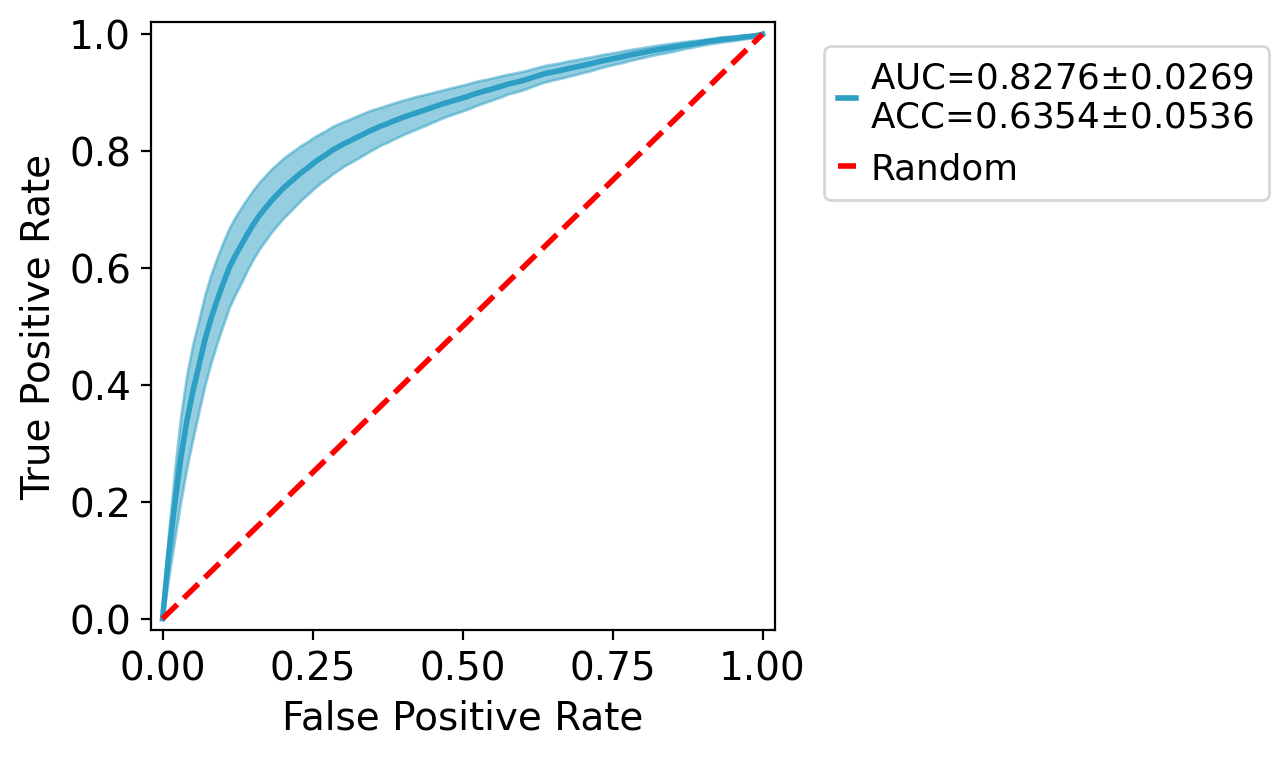

In [17]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')